In [1]:
from typing import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from constants import DATA_DIR

from astrofit.model import Asteroid, Lightcurve, LightcurveBin
from astrofit.model.enums import SortOptionEnum
from astrofit.utils import (
    AsteroidLoader,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)
from astrofit.utils.enums import BinningMethodEnum

In [2]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

In [3]:
asteroids = sorted((
    asteroid_loader.load_asteroid(name) for name in asteroid_loader.available_asteroids
), key=lambda asteroid: asteroid.period)
asteroids

[Asteroid(id=29204, name=Ladegast, period=2.031527, lightcurves=1),
 Asteroid(id=52820, name=1998 RS2, period=2.134122, lightcurves=1),
 Asteroid(id=7779, name=Susanring, period=2.19003, lightcurves=1),
 Asteroid(id=138831, name=2000 UD68, period=2.28689, lightcurves=1),
 Asteroid(id=16118, name=Therberens, period=2.28855, lightcurves=1),
 Asteroid(id=13688, name=Oklahoma, period=2.38144, lightcurves=1),
 Asteroid(id=2102, name=Tantalus, period=2.39006, lightcurves=22),
 Asteroid(id=8600, name=Arundinaceus, period=2.40106, lightcurves=1),
 Asteroid(id=14664, name=Vandervelden, period=2.454632, lightcurves=2),
 Asteroid(id=8936, name=Gianni, period=2.46755, lightcurves=1),
 Asteroid(id=3476, name=Dongguan, period=2.5131, lightcurves=1),
 Asteroid(id=2962, name=Otto, period=2.536321, lightcurves=1),
 Asteroid(id=232888, name=2004 XG17, period=2.541845, lightcurves=1),
 Asteroid(id=19898, name=1177 T-3, period=2.557692, lightcurves=2),
 Asteroid(id=6053, name=1993 BW3, period=2.57386, lig

In [4]:
np.percentile([asteroid.period for asteroid in asteroids], [5, 25, 50, 75, 90, 95])

array([  3.422438,   5.48469 ,   8.78678 ,  16.97036 ,  49.0198  ,
       108.6936  ])

In [23]:
asteroid, = [asteroid for asteroid in asteroids if asteroid.name == "Eros"]
asteroid

Asteroid(id=433, name=Eros, period=5.27025528, lightcurves=112)

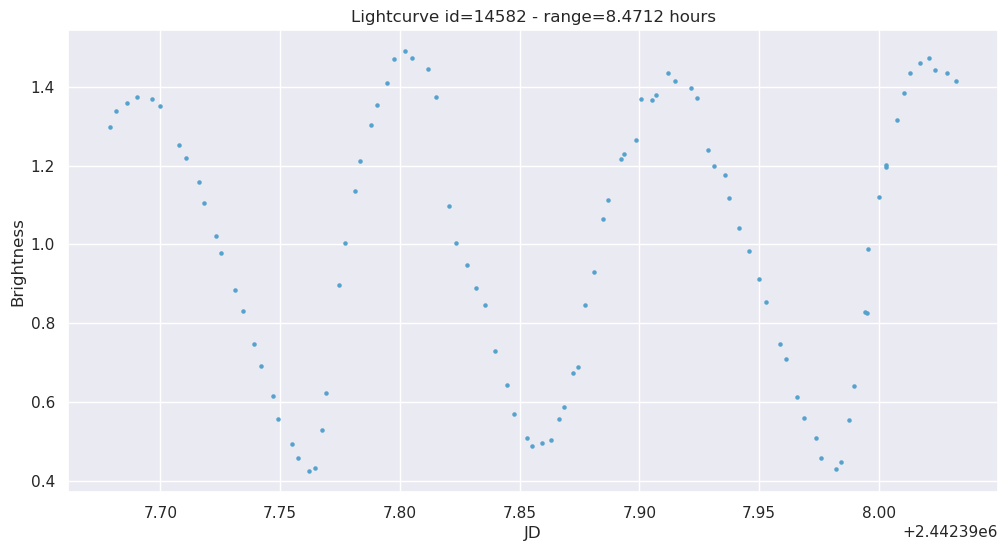

In [24]:
asteroid.get_longest_lightcurve(by=EnumSortOption.PERIOD).plot()

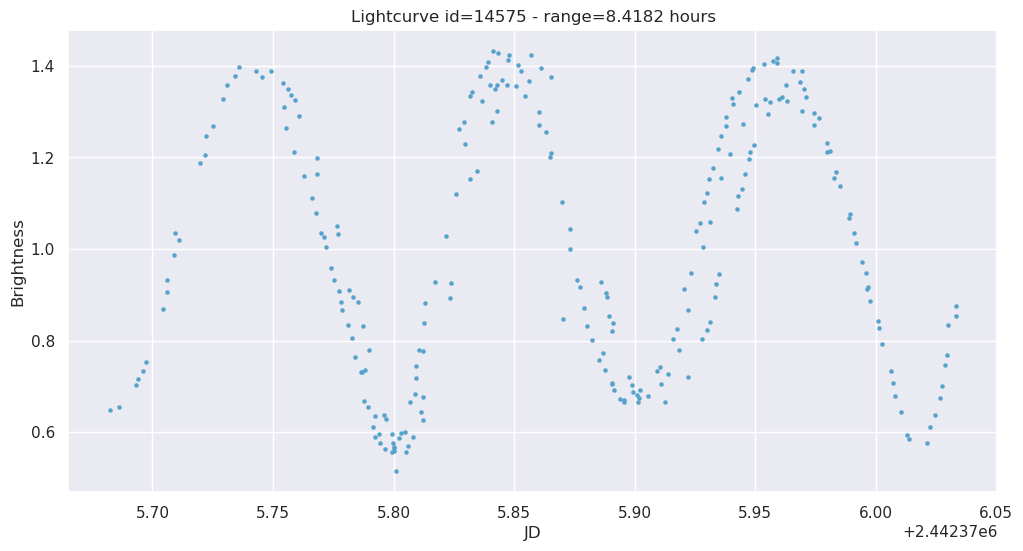

In [25]:
asteroid.get_longest_lightcurve(by=EnumSortOption.POINTS).plot()

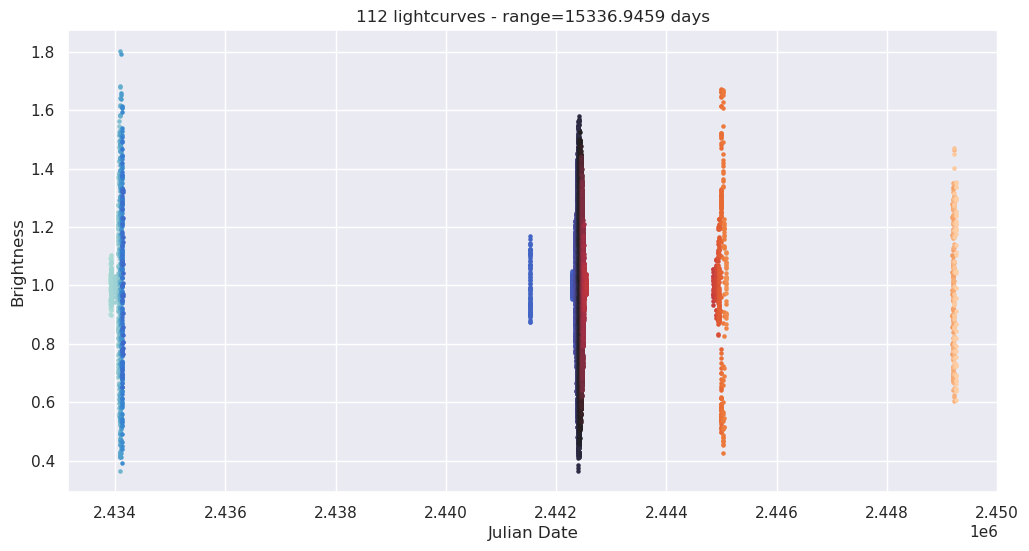

In [26]:
lightcurve_plotter.plot_lightcurves(asteroid.lightcurves, split_plots=False)

In [27]:
splitted = lightcurve_splitter.split_lightcurves(
    asteroid.lightcurves,
    max_hours_diff=24,
    min_no_points=10,
)
splitted

[Lightcurve(id=14537, period=5.36100h, points_count=21, first_JD=2433915.385708, last_JD=2433915.609083),
 Lightcurve(id=14538, period=4.54102h, points_count=21, first_JD=2433924.262458, last_JD=2433924.451667),
 Lightcurve(id=14539, period=6.00502h, points_count=30, first_JD=2433931.254458, last_JD=2433931.504667),
 Lightcurve(id=14540, period=5.46199h, points_count=36, first_JD=2433934.379917, last_JD=2433934.6075),
 Lightcurve(id=14541, period=4.00200h, points_count=24, first_JD=2433994.339708, last_JD=2433994.506458),
 Lightcurve(id=14542, period=4.48200h, points_count=31, first_JD=2434054.244958, last_JD=2434054.431708),
 Lightcurve(id=14543, period=2.75501h, points_count=28, first_JD=2434055.289375, last_JD=2434055.404167),
 Lightcurve(id=14544, period=3.63199h, points_count=23, first_JD=2434068.315042, last_JD=2434068.466375),
 Lightcurve(id=14545, period=2.85698h, points_count=23, first_JD=2434078.283292, last_JD=2434078.402333),
 Lightcurve(id=14546, period=2.68699h, points_co

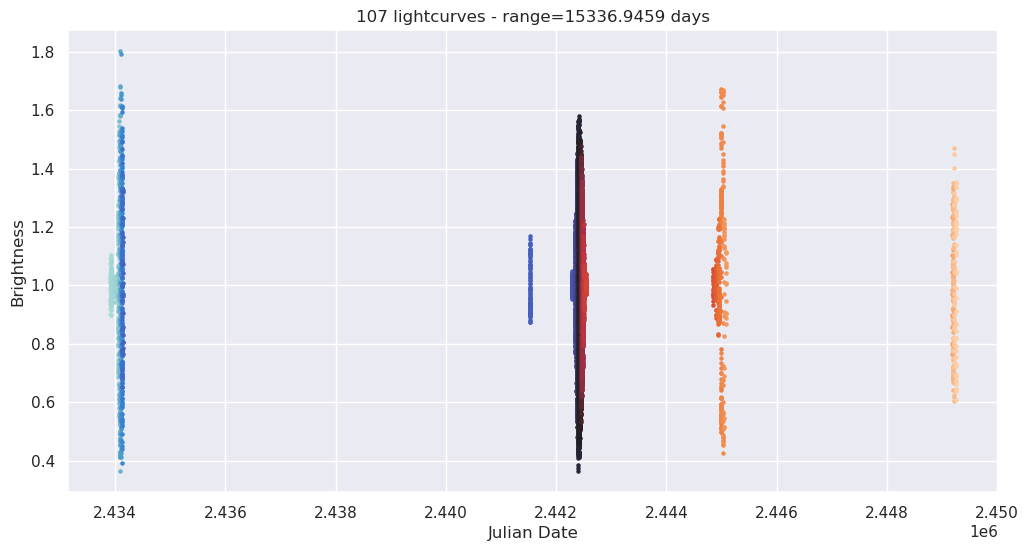

In [29]:
lightcurve_plotter.plot_lightcurves(splitted, split_plots=False)

In [30]:
bins = lightcurve_binner.bin_lightcurves(
    splitted,
    max_time_diff=45,
    binning_method=BinningMethodEnum.FIRST_TO_FIRST_DIFF,
)
bins = sorted(bins, key=lambda bin: bin.points_count, reverse=True)
bins

[LightcurveBin(lightcurves=20, period=37.20147h, points=1994),
 LightcurveBin(lightcurves=17, period=45.13657h, points=1717),
 LightcurveBin(lightcurves=8, period=38.23932h, points=805),
 LightcurveBin(lightcurves=8, period=27.15137h, points=382),
 LightcurveBin(lightcurves=11, period=44.22867h, points=296),
 LightcurveBin(lightcurves=12, period=35.12167h, points=290),
 LightcurveBin(lightcurves=4, period=44.17007h, points=188),
 LightcurveBin(lightcurves=7, period=31.00688h, points=181),
 LightcurveBin(lightcurves=4, period=19.22179h, points=108),
 LightcurveBin(lightcurves=2, period=3.13984h, points=86),
 LightcurveBin(lightcurves=1, period=6.29122h, points=78),
 LightcurveBin(lightcurves=3, period=33.08960h, points=65),
 LightcurveBin(lightcurves=2, period=33.17630h, points=64),
 LightcurveBin(lightcurves=3, period=23.23206h, points=58),
 LightcurveBin(lightcurves=2, period=1.05117h, points=44),
 LightcurveBin(lightcurves=1, period=2.84515h, points=44),
 LightcurveBin(lightcurves=1,

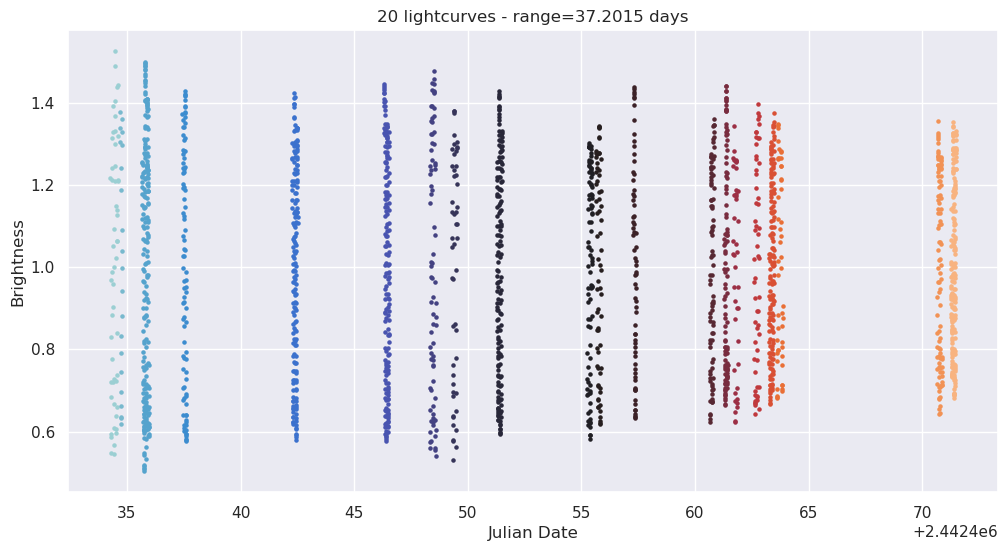

In [31]:
_bin = bins[0]
lightcurve_plotter.plot_lightcurves(_bin, split_plots=False)

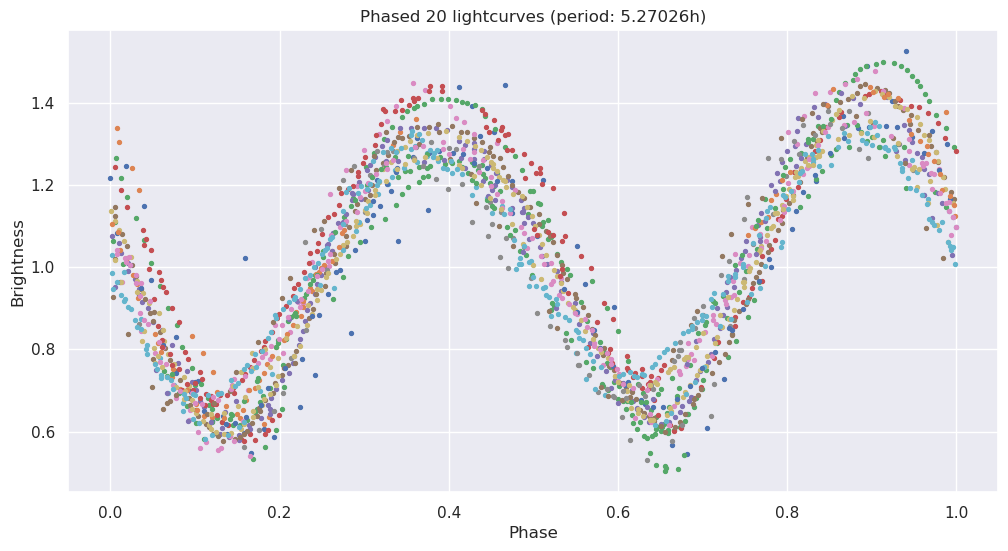

In [32]:
lightcurve_plotter.plot_phased_lightcurves(_bin, period=asteroid.period)

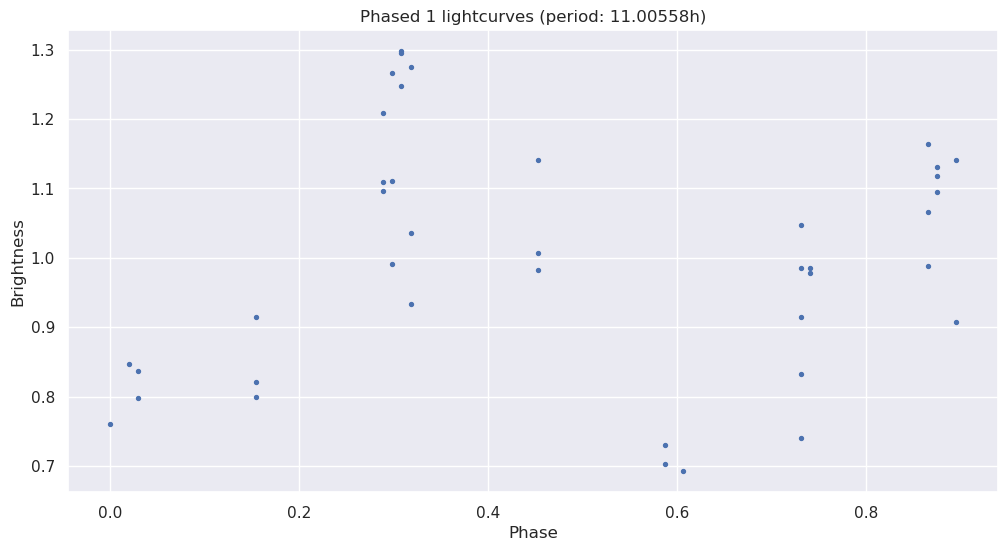

In [ ]:
lightcurve_plotter.plot_phased_lightcurves(_bin, period=asteroid.period - 0.02)

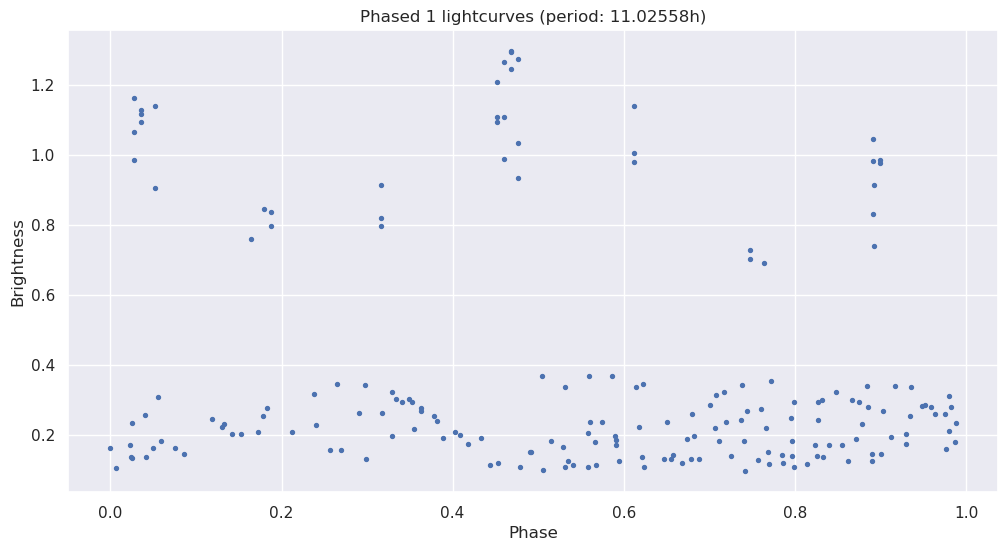

In [ ]:
lightcurve_plotter.plot_phased_lightcurves(asteroid.lightcurves, period=asteroid.period)

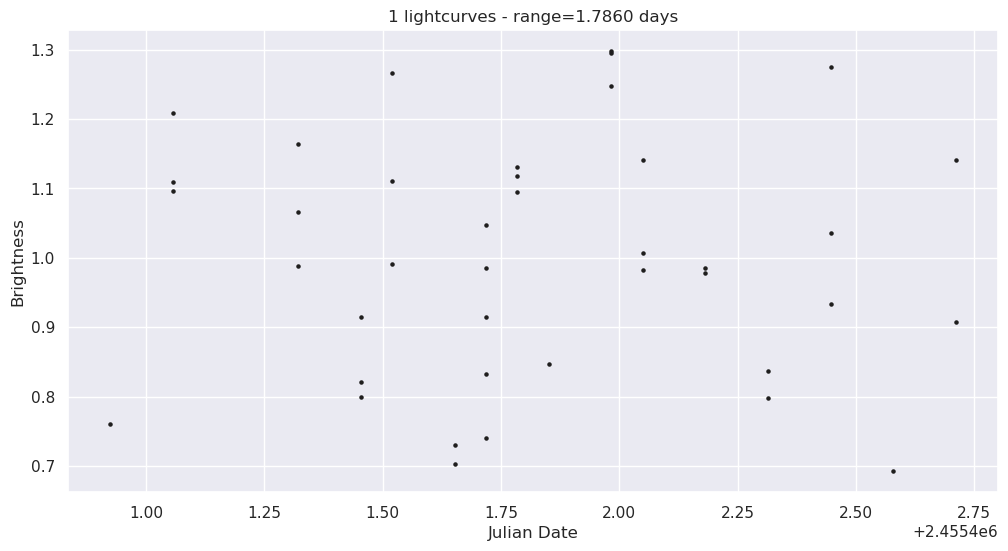

In [ ]:
lightcurve_plotter.plot_lightcurves(_bin)

In [ ]:
asteroid.period

11.02558

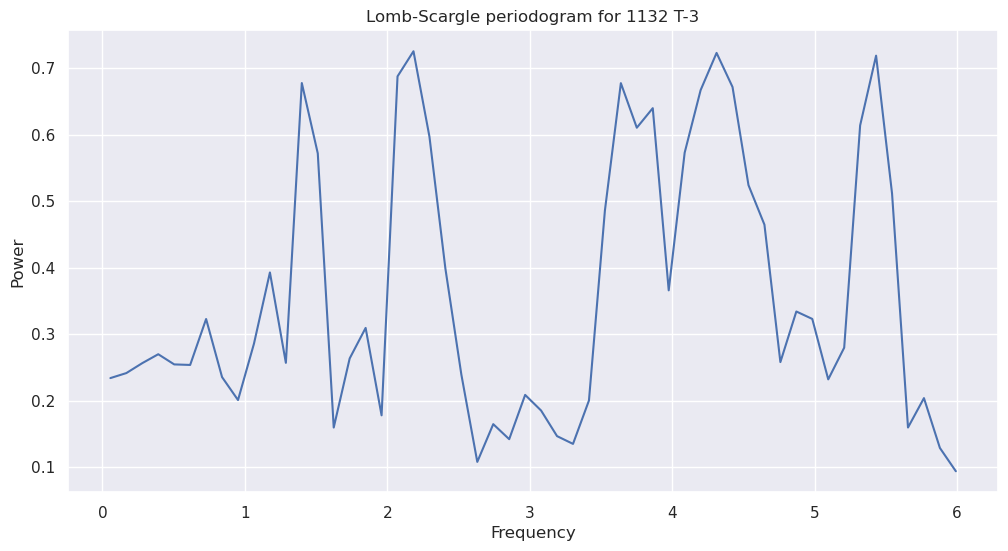

In [ ]:
freq, power = LombScargle(_bin.times, _bin.brightnesses, nterms=3).autopower(maximum_frequency=6)

idx = np.argsort(power)[::-1][:100]
top_k_freqs = freq[idx]

fig = plt.plot(freq, power)

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title(f"Lomb-Scargle periodogram for {asteroid.name}")
plt.show()

In [ ]:
asteroid.period

11.02558